# 1. Trainining a DCGAN on MNSIT database

Importing required libraries for this task

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display

Importing the MNSIT dataset from tf.keras and settting up thr training dataset

In [13]:
# Load and prepare the MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Created a function which sets up the generated model with the required layers.

Generator Model Specifications:-
Number of Layers: The model consists of 12 layers, including Dense, Reshape, Conv2DTranspose, BatchNormalization, and LeakyReLU layers.

Dense Layer: This layer takes a 100-dimensional input vector and has 7 * 7 * 256 = 12,544 output neurons. It does not use a bias term.

Reshape Layer: Reshapes the output dense layer into a tensor with dimensions (7, 7, 256), for the following convol layers.

Conv2DTranspose Layers:

The first Conv2DTranspose layer
128 filters of size (5, 5), with strides of (1, 1)

The second Conv2DTranspose layer
64 filters of size (5, 5), with strides of (2, 2)

The third Conv2DTranspose layer
1 filter of size (5, 5), with strides of (2, 2)



Output Shape: The final output shape of the model is (None, 28, 28, 1), where None represents the batch size. This suggests that the model generates grayscale images of size 28x28 pixels.

In [42]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

In [15]:

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

In [16]:
# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
# Checkpoints to save the models
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [38]:
# Training function
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Store the losses
generator_losses = []
discriminator_losses = []

In [39]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [40]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

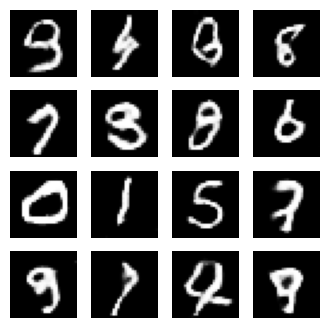

In [41]:

for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    # Save the losses to the lists
    generator_losses.append(gen_loss)
    discriminator_losses.append(disc_loss)

    # Print epoch and progress
    print(f'Epoch {epoch + 1}/{EPOCHS} - Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}, Time: {time.time() - start:.2f} sec')

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

# Generate after the final epoch
display.clear_output(wait=True)
generate_and_save_images(generator, EPOCHS, seed)



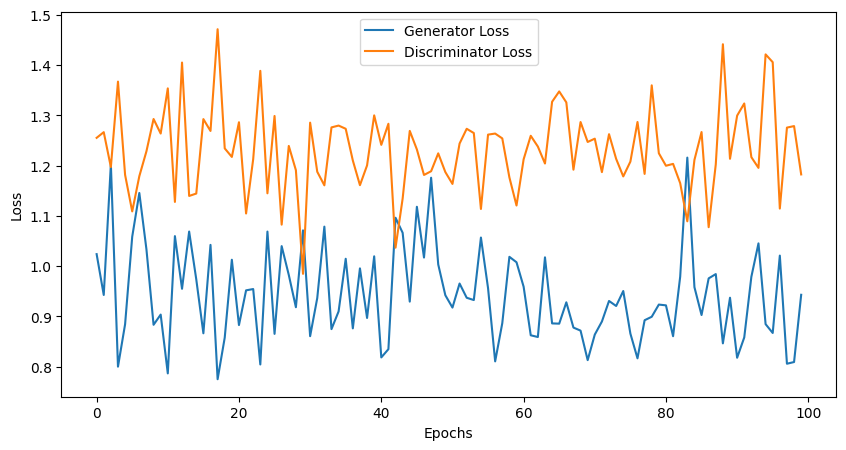

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [46]:
min_gen_loss = min(generator_losses)
min_disc_loss = min(discriminator_losses)

print(f"Minimum Discriminator Loss: {min_disc_loss}")
print(f"Minimum Generator Loss: {min_gen_loss}")


Minimum Discriminator Loss: 0.9845625758171082
Minimum Generator Loss: 0.774956464767456


# 2. Adding More Layers for better Accuracy

I have added another convolve layer group
model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 28, 28, 32)

In [50]:

# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Ensure correct output shape

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 7, 7, 128)  # Ensure correct output shape

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 14, 14, 64)  # Ensure correct output shape

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 28, 28, 32)  # Ensure correct output shape

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)  # Ensure correct output shape

    return model


generator = make_generator_model()

Used the same discriminator as before

In [51]:
discriminator = make_discriminator_model()

In [56]:
# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [57]:
# Checkpoints to save the models
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [58]:
# Training function
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Store the losses
generator_losses = []
discriminator_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [59]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

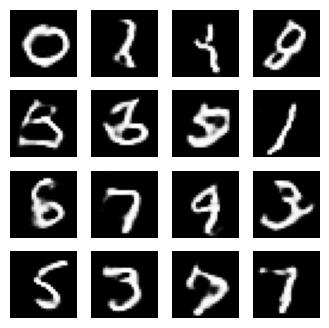

In [60]:
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    # Save the losses to the lists
    generator_losses.append(gen_loss)
    discriminator_losses.append(disc_loss)

    # Print epoch and progress
    print(f'Epoch {epoch + 1}/{EPOCHS} - Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}, Time: {time.time() - start:.2f} sec')

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

# Generate after the final epoch
display.clear_output(wait=True)
generate_and_save_images(generator, EPOCHS, seed)

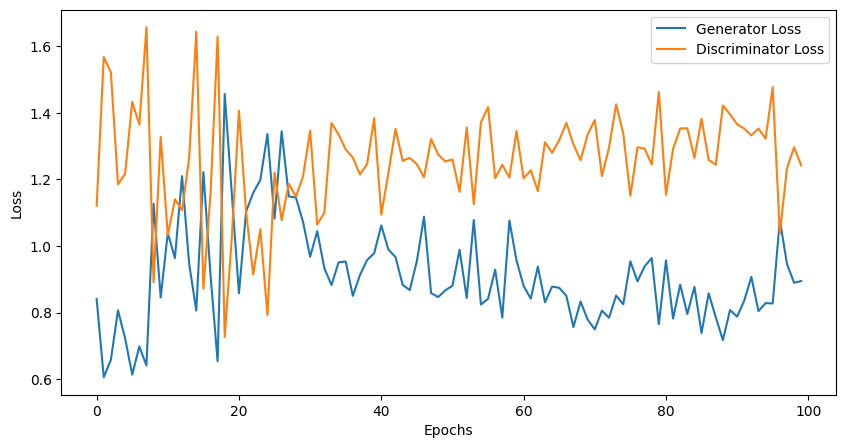

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [62]:
min_gen_loss = min(generator_losses)
min_disc_loss = min(discriminator_losses)

print(f"Minimum Discriminator Loss: {min_disc_loss}")
print(f"Minimum Generator Loss: {min_gen_loss}")


Minimum Discriminator Loss: 0.7266603112220764
Minimum Generator Loss: 0.6054959297180176


Due to the additional layer, the minimum generator loss decreased by about 20 % compared to the previous model

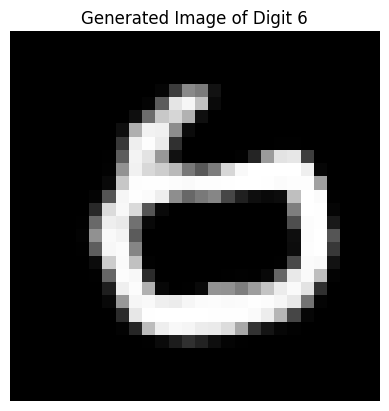

In [121]:
def generate_digit_image(digit, generator_model):
    # Check if the digit is valid
    if digit < 0 or digit > 9:
        print("Invalid digit. Please provide a digit between 0 and 9.")
        return

    # Generate a noise vector
    noise = tf.random.normal([1, noise_dim])

    # Generate an image of the specified digit using the generator
    generated_image = generator_model(noise, training=False)

    # Display the generated image
    plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    plt.title(f'Generated Image of Digit {digit}')
    plt.show()

# Example usage:
digit_to_generate = 6  # Change this to any digit between 0 and 9
generate_digit_image(digit_to_generate, generator)


# Conclusion

Although a significant decrease was observed on adding another layer, in the later epochs, it can be observed that the loss was somewhat chaotic and the picture were only slighly better compared to the simpler counterpart.

More tuning and testing needed.